In [1]:
import sqlite3
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
# Time series analysis
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

In [2]:
# read data
cal = pd.read_csv('calendar.csv') #calendar data
sales_train = pd.read_csv('sales_train_validation.csv') #sales_train data 
sell_price = pd.read_csv('sell_prices.csv') #sell_price data
sample = pd.read_csv('sample_submission.csv')

In [3]:
# see how data look like
sample.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
sell_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [6]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [7]:
# see the shape of data

print("Train data: {}".format(sales_train.shape))
print("Calender data: {}".format(cal.shape))
print("Sell Price data: {}".format(sell_price.shape))
print("Sample data: {}".format(sample.shape))

Train data: (30490, 1919)
Calender data: (1969, 14)
Sell Price data: (6841121, 4)
Sample data: (60980, 29)


In [8]:
# change the data type of date in calendar data

cal['Date_dt']=pd.to_datetime(cal['date'])

In [9]:
# create sql db file
fn = './Walmart_data.db'
conn = sqlite3.connect(fn)
cur = conn.cursor()

In [10]:
# store sell_price and calendar data into the database
# train data consists of two many columns, so in this project we'll directly use python to deal with it
r = cur.execute('''DROP TABLE IF EXISTS sell_price''')
r = cur.execute('''DROP TABLE IF EXISTS cal''')
conn.commit()

# insert into sql
sell_price.to_sql(name='sell_price', con=conn,if_exists='append',index=False)
cal.to_sql(name='cal', con=conn,if_exists='append',index=False)

In [11]:
#data copy

train = sales_train.copy()
calendar = cal.copy()
price = sell_price.copy()

In [12]:
cur.execute("select year,count(event_name_1),count(event_type_1),count(event_name_2),count(event_type_2) from cal group by year")
# pd.Series(cur.description).map(lambda x:x[0])
cur.fetchall()

[(2011, 26, 26, 1, 1),
 (2012, 30, 30, 0, 0),
 (2013, 29, 29, 1, 1),
 (2014, 28, 28, 2, 2),
 (2015, 30, 30, 0, 0),
 (2016, 19, 19, 1, 1)]

In [13]:
# check calender data

# Number of events per year
cur.execute("select year,count(event_name_1),count(event_type_1),count(event_name_2),count(event_type_2) from cal group by year")
cur.fetchall()

[(2011, 26, 26, 1, 1),
 (2012, 30, 30, 0, 0),
 (2013, 29, 29, 1, 1),
 (2014, 28, 28, 2, 2),
 (2015, 30, 30, 0, 0),
 (2016, 19, 19, 1, 1)]

In [14]:
# Number of flags per year by store
cur.execute("select year,sum(snap_CA),sum(snap_TX),sum(snap_WI) from cal group by year")
cur.fetchall()

[(2011, 110, 110, 110),
 (2012, 120, 120, 120),
 (2013, 120, 120, 120),
 (2014, 120, 120, 120),
 (2015, 120, 120, 120),
 (2016, 60, 60, 60)]

In [15]:
# check sell_price data

# number of stores
cur.execute("select count(store_id) from (select DISTINCT store_id from sell_price) union select DISTINCT store_id from sell_price")
cur.fetchall()

[(10,),
 ('CA_1',),
 ('CA_2',),
 ('CA_3',),
 ('CA_4',),
 ('TX_1',),
 ('TX_2',),
 ('TX_3',),
 ('WI_1',),
 ('WI_2',),
 ('WI_3',)]

In [16]:
# number of items
cur.execute("select count(item_id) from (select DISTINCT item_id from sell_price) union select DISTINCT item_id from sell_price")
cur.fetchall()

[(3049,),
 ('FOODS_1_001',),
 ('FOODS_1_002',),
 ('FOODS_1_003',),
 ('FOODS_1_004',),
 ('FOODS_1_005',),
 ('FOODS_1_006',),
 ('FOODS_1_008',),
 ('FOODS_1_009',),
 ('FOODS_1_010',),
 ('FOODS_1_011',),
 ('FOODS_1_012',),
 ('FOODS_1_013',),
 ('FOODS_1_014',),
 ('FOODS_1_015',),
 ('FOODS_1_016',),
 ('FOODS_1_017',),
 ('FOODS_1_018',),
 ('FOODS_1_019',),
 ('FOODS_1_020',),
 ('FOODS_1_021',),
 ('FOODS_1_022',),
 ('FOODS_1_023',),
 ('FOODS_1_024',),
 ('FOODS_1_025',),
 ('FOODS_1_026',),
 ('FOODS_1_027',),
 ('FOODS_1_028',),
 ('FOODS_1_029',),
 ('FOODS_1_030',),
 ('FOODS_1_031',),
 ('FOODS_1_032',),
 ('FOODS_1_033',),
 ('FOODS_1_034',),
 ('FOODS_1_035',),
 ('FOODS_1_036',),
 ('FOODS_1_037',),
 ('FOODS_1_038',),
 ('FOODS_1_039',),
 ('FOODS_1_040',),
 ('FOODS_1_041',),
 ('FOODS_1_042',),
 ('FOODS_1_043',),
 ('FOODS_1_044',),
 ('FOODS_1_045',),
 ('FOODS_1_046',),
 ('FOODS_1_047',),
 ('FOODS_1_048',),
 ('FOODS_1_049',),
 ('FOODS_1_050',),
 ('FOODS_1_051',),
 ('FOODS_1_052',),
 ('FOODS_1_053',),
 (

In [17]:
# average of prices

cur.execute("select avg(sell_price) from sell_price")
cur.fetchall()

[(4.41095238924595,)]

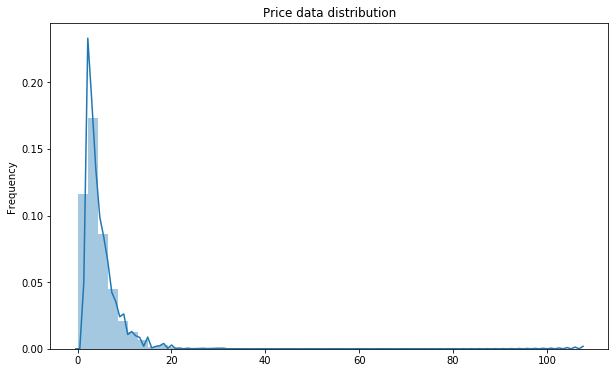

In [18]:
# check the distribution of prices

cur.execute("select sell_price from sell_price")
plt.figure(figsize=(10,6))
sns.distplot(cur.fetchall())
plt.title("Price data distribution")
plt.ylabel("Frequency");

In [19]:
# average of price by store

cur.execute("select store_id, avg(sell_price) from sell_price group by store_id")
cur.fetchall()

[('CA_1', 4.414232816724471),
 ('CA_2', 4.445500262778929),
 ('CA_3', 4.388228821732322),
 ('CA_4', 4.42157973564122),
 ('TX_1', 4.374568974378535),
 ('TX_2', 4.366766279615124),
 ('TX_3', 4.387365173798334),
 ('WI_1', 4.457711709646401),
 ('WI_2', 4.4417170300627005),
 ('WI_3', 4.418116619298259)]

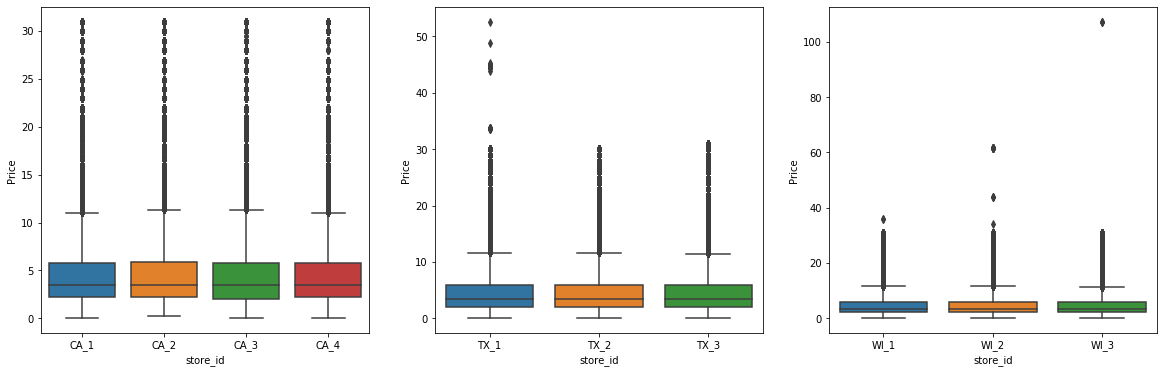

In [20]:
# draw box plot

cur.execute("select * from sell_price where store_id like 'CA%'")

store_df = []
store_df.append(pd.read_sql_query("select * from sell_price where store_id like 'CA%'",conn))
store_df.append(pd.read_sql_query("select * from sell_price where store_id like 'TX%'",conn))
store_df.append(pd.read_sql_query("select * from sell_price where store_id like 'WI%'",conn))

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(len(store_df)):
    sns.boxplot(x="store_id", y="sell_price", data=store_df[i], ax=ax[i])
    ax[i].set_ylabel("Price")

In [21]:
# analyze of train data

print('*'*30, 'Item_Id','*'*30 )
print("Item Id unique value count {}".format(len(train['item_id'].unique())))
print(train['item_id'].unique())

print("*"*30, "dept_id", "*"*30)
print("dept_id unique value counts:{}".format(len(train["dept_id"].unique())))
print(train["store_id"].unique())

print("*"*30, "cat_id", "*"*30)
print("cat_id unique value counts:{}".format(len(train["cat_id"].unique())))
print(train["cat_id"].unique())

print("*"*30, "state_id", "*"*30)
print("state_id unique value counts:{}".format(len(train["state_id"].unique())))
print(train["state_id"].unique())

****************************** Item_Id ******************************
Item Id unique value count 3049
['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'
 'FOODS_3_826' 'FOODS_3_827']
****************************** dept_id ******************************
dept_id unique value counts:7
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
****************************** cat_id ******************************
cat_id unique value counts:3
['HOBBIES' 'HOUSEHOLD' 'FOODS']
****************************** state_id ******************************
state_id unique value counts:3
['CA' 'TX' 'WI']


In [22]:
# Create dataframe by grouping
state_group = train.groupby("state_id").sum().T
state_group = pd.merge(state_group, calendar, left_index=True, right_on="d", how="left").set_index("Date_dt")

c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

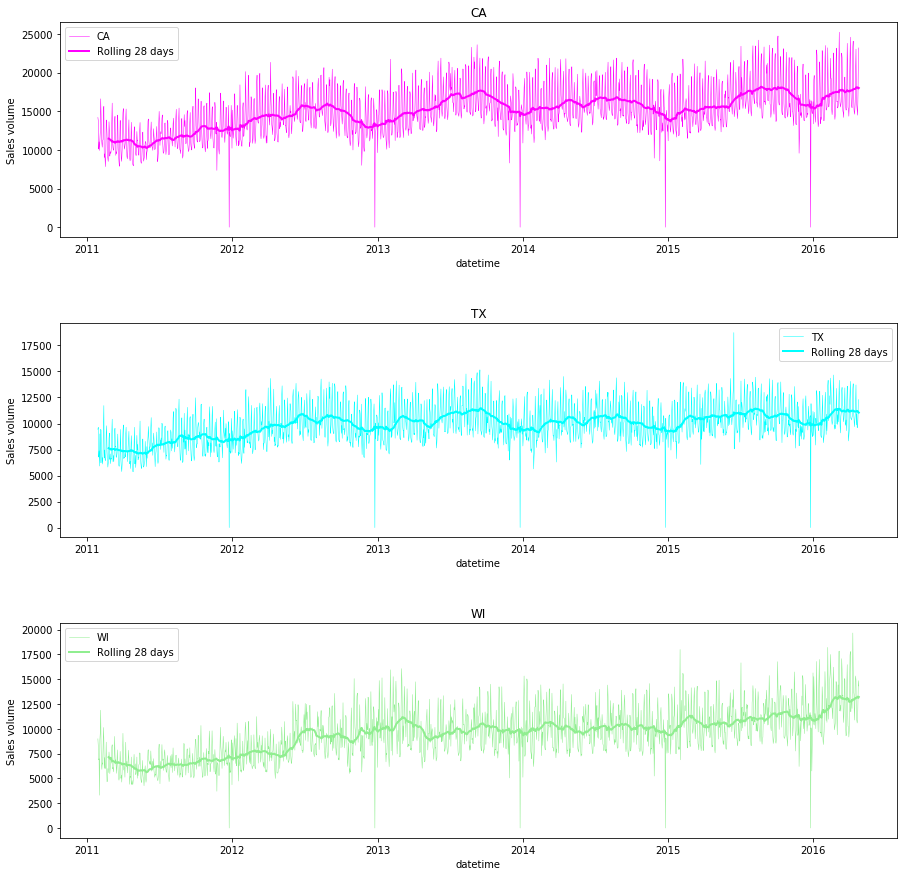

In [23]:
# Visualization
fig, ax = plt.subplots(3,1, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)

color=["magenta", "cyan", "lightgreen"]
state_col = train["state_id"].unique()

for i in range(len(state_col)):
    ax[i].plot(state_group.index, state_group[state_col[i]], color=color[i], linewidth=0.5)
    # Rolling
    ax[i].plot(state_group.index, state_group[state_col[i]].rolling(28).mean(), color=color[i], linewidth=2)
    ax[i].set_xlabel("datetime")
    ax[i].set_ylabel("Sales volume")
    ax[i].legend(["{}".format(state_col[i]), "Rolling 28 days"])
    ax[i].set_title("{}".format(state_col[i]))

c:\Users\meigu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


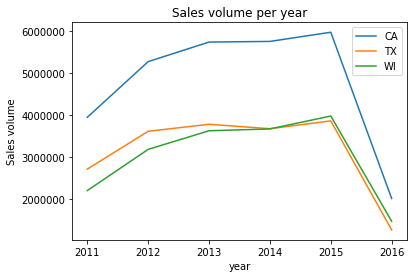

In [24]:
# Sales volume per year
state_group.groupby("year")['CA', 'TX', 'WI'].sum().plot()
plt.title("Sales volume per year")
plt.ylabel("Sales volume");

In [25]:
# Xmas
Xmas_date = [pd.datetime(2011,12,25), pd.datetime(2012,12,25), pd.datetime(2013,12,25), pd.datetime(2014,12,25), pd.datetime(2015,12,25)]

# Drop Xmas date
state_group.drop(Xmas_date, inplace=True)

c:\Users\meigu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [26]:
# store new data in SQL
r = cur.execute('''DROP TABLE IF EXISTS state_group''')
conn.commit()
state_group.to_sql(name='state_group', con=conn,if_exists='append',index=False)

In [27]:
# Define time series analysis function
def plot_ts_decomp(base,col, lag, color):
    print("Analised Data:{}".format(col.upper()))
    # Stats model
    data=pd.read_sql_query("SELECT date, "+ col +" from " + base ,conn).set_index('date')
    data.index=pd.to_datetime(data.index)
    res = sm.tsa.seasonal_decompose(data[col], period=lag)
    data["trend"] = res.trend
    data["seaso"] = res.seasonal
    data["resid"] = res.resid
    
    # Visualization
    fig = plt.figure(figsize=(20,15))
    grid = plt.GridSpec(4,2, hspace=0.4, wspace=0.2)
    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[1,0])
    ax3 = fig.add_subplot(grid[2,0])
    ax4 = fig.add_subplot(grid[3,0])
    ax5 = fig.add_subplot(grid[:-2,1])
    ax6 = fig.add_subplot(grid[2:,1])
    
    # raw price data
    ax1.plot(data.index, data[col], label="price of {}".format(col), color=color, linewidth=0.5)
    ax1.plot(data.index, data[col].rolling(lag//12).mean(), label="Rolling {}".format(lag//12), color=color, linewidth=2)
    ax1.set_xlabel("date")
    ax1.set_ylabel("price")
    ax1.set_title("raw data")
    ax1.legend()
    # trend
    ax2.plot(data.index, data["trend"], label="trend of {}".format(col), color=color, linewidth=3)
    ax2.set_xlabel("date")
    ax2.set_ylabel("trend")
    ax2.set_title("trend")
    ax2.legend()
    # seasonaly
    ax3.plot(data.index, data["seaso"], label="seasonaly of {}".format(col), color=color, linewidth=0.5)
    ax3.set_xlabel("date")
    ax3.set_ylabel("seasonaly")
    ax3.set_title("seasonaly")
    ax3.legend()
    # residual
    ax4.plot(data.index, data["resid"], label="residual error of {}".format(col), color=color, linewidth=0.5)
    ax4.set_xlabel("date")
    ax4.set_ylabel("residual error")
    ax4.set_title("residual")
    ax4.legend()
    # distribution
    sns.distplot(data[col], ax=ax5)
    ax5.set_xlabel("Price")
    ax5.set_ylabel("Frequency")
    ax5.set_title("distribution")
    # auto correlation
    autocorrelation_plot(data[col], ax=ax6, linewidth=0.5)
    ax6.set_title("autocorrelation")

Analised Data:CA


c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

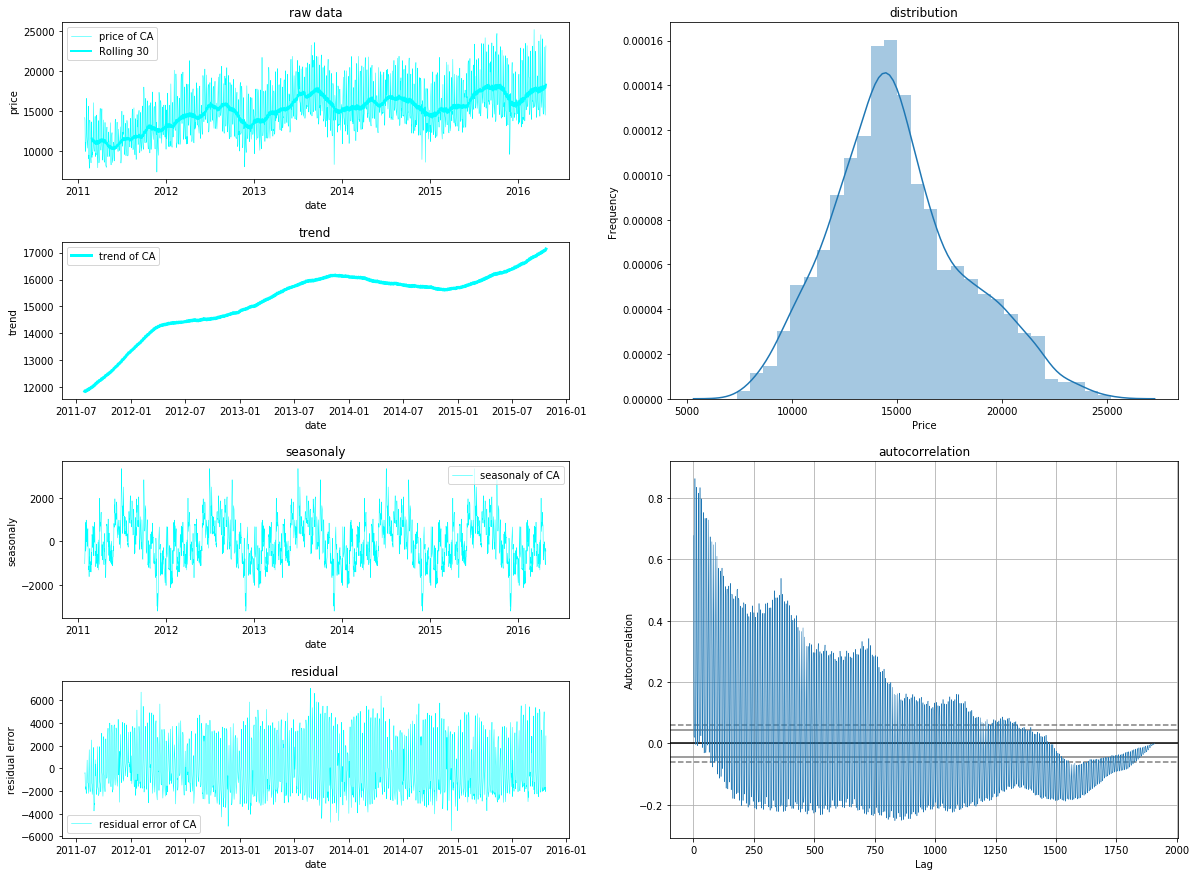

In [28]:
# CA of state
plot_ts_decomp("state_group", "CA", 365, "aqua");

Analised Data:TX


c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

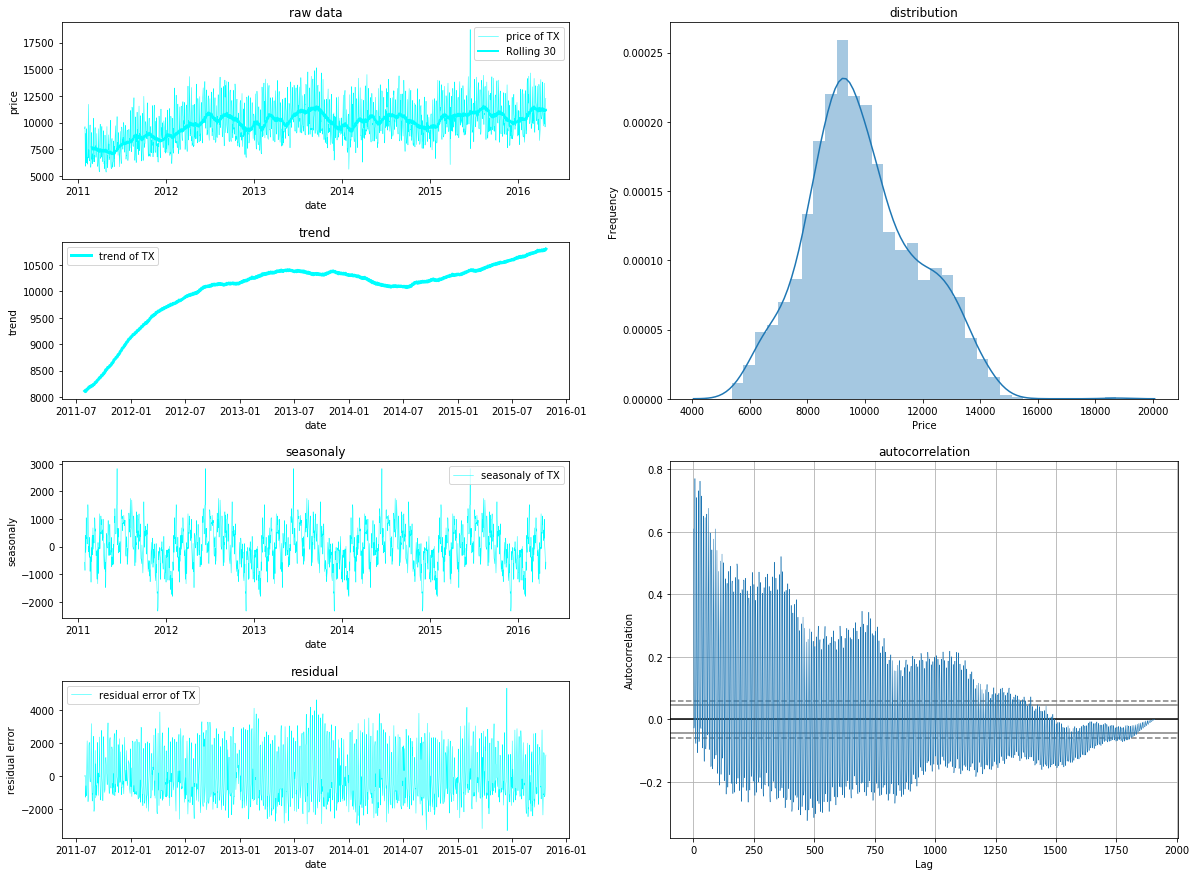

In [29]:
# TX of state
plot_ts_decomp("state_group", "TX", 365, "aqua");

Analised Data:WI


c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

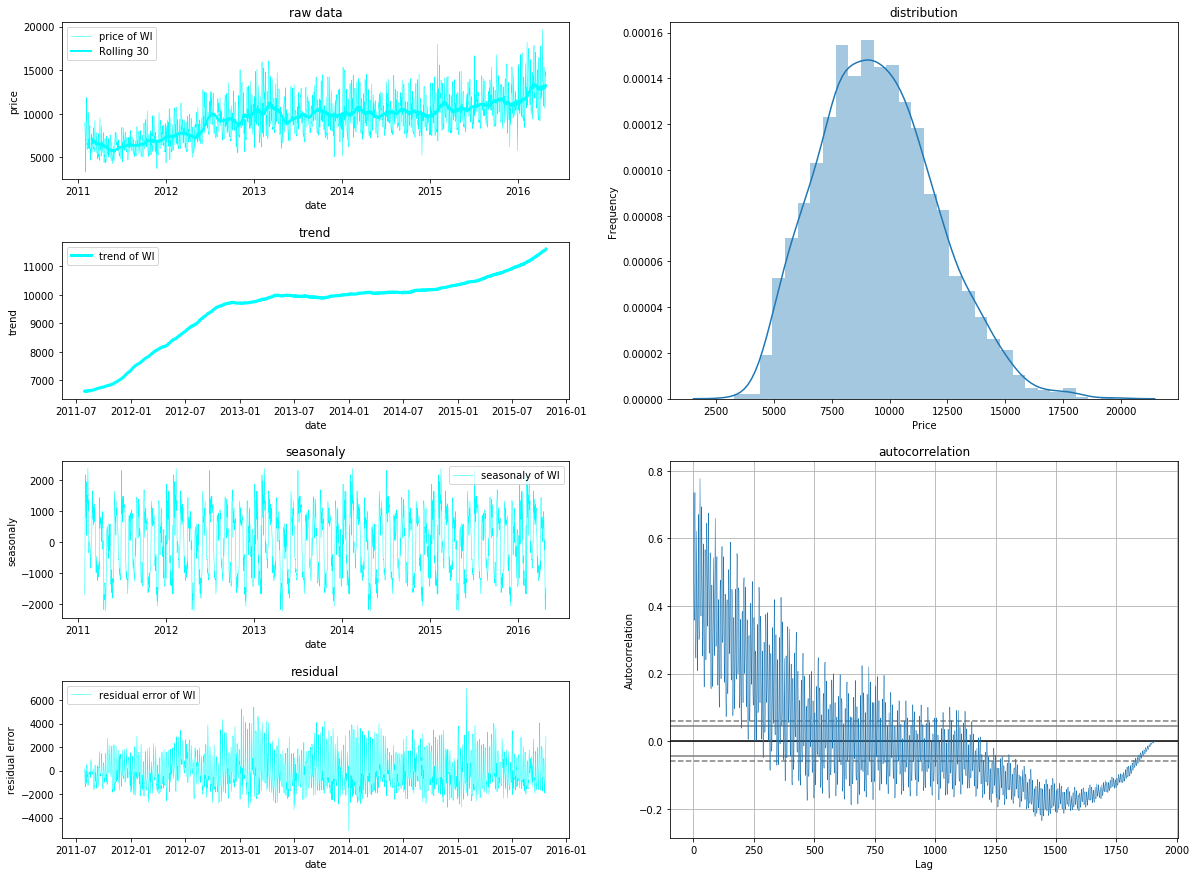

In [30]:
# WI of state
plot_ts_decomp("state_group", "WI", 365, "aqua");

c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

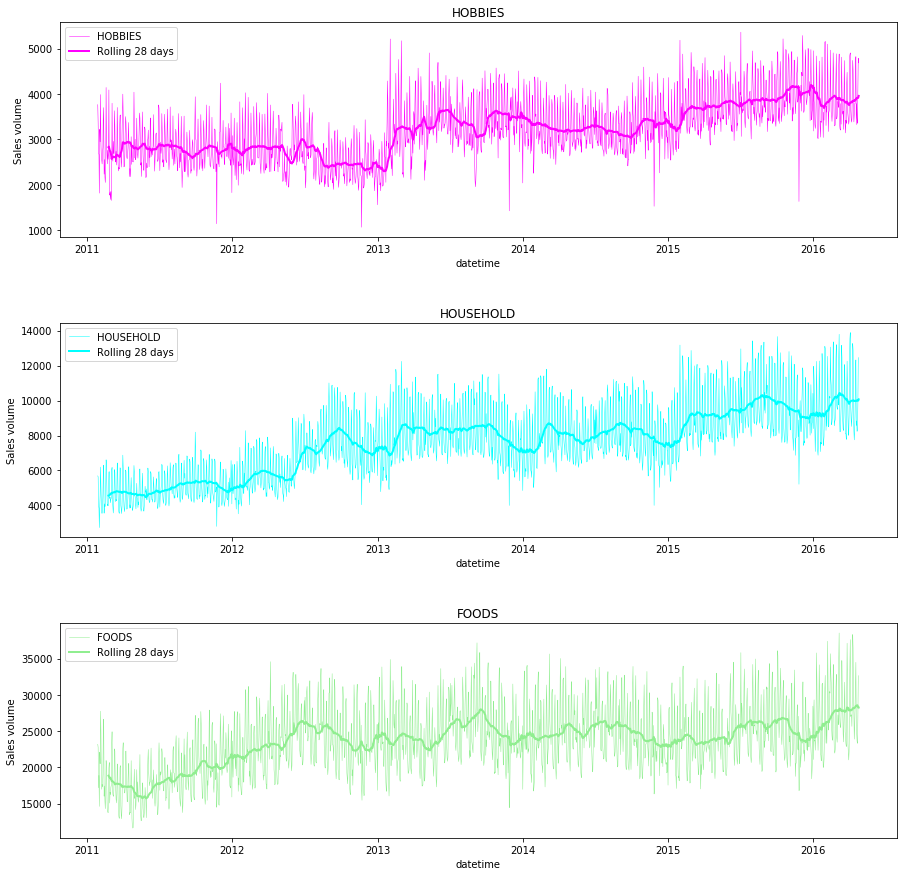

In [31]:
# Create dataframe by grouping
cate_group = train.groupby("cat_id").sum().T
cate_group = pd.merge(cate_group, calendar, left_index=True, right_on="d", how="left").set_index("Date_dt")

# Drop Xmas date
cate_group.drop(Xmas_date, inplace=True)

# Visualization
fig, ax = plt.subplots(3,1, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)

color=["magenta", "cyan", "lightgreen"]
cate_col = train["cat_id"].unique()

for i in range(len(cate_col)):
    ax[i].plot(cate_group.index, cate_group[cate_col[i]], color=color[i], linewidth=0.5)
    # Rolling
    ax[i].plot(cate_group.index, cate_group[cate_col[i]].rolling(28).mean(), color=color[i], linewidth=2)
    ax[i].set_xlabel("datetime")
    ax[i].set_ylabel("Sales volume")
    ax[i].legend(["{}".format(cate_col[i]), "Rolling 28 days"])
    ax[i].set_title("{}".format(cate_col[i]))

c:\Users\meigu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


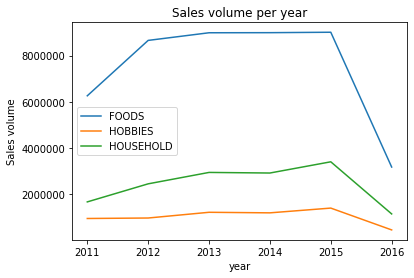

In [32]:
# Sales volume per year
cate_group.groupby("year")['FOODS', 'HOBBIES', 'HOUSEHOLD'].sum().plot()
plt.title("Sales volume per year")
plt.ylabel("Sales volume");

In [33]:
# store new data in SQL
r = cur.execute('''DROP TABLE IF EXISTS cate_group''')
conn.commit()
cate_group.to_sql(name='cate_group', con=conn,if_exists='append',index=False)

Analised Data:HOBBIES


c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

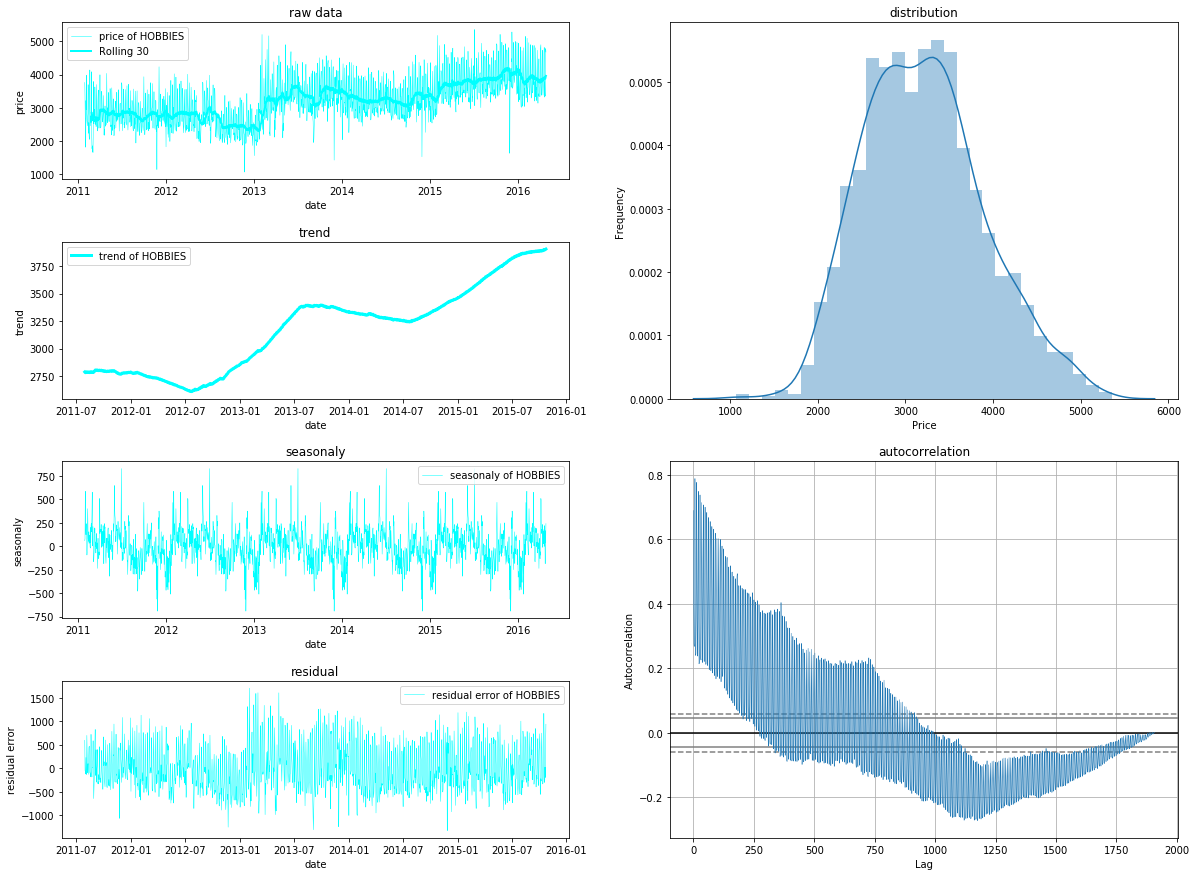

In [34]:
# HOBBIES of cat
plot_ts_decomp("cate_group", "HOBBIES", 365, "aqua");

Analised Data:HOUSEHOLD


c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

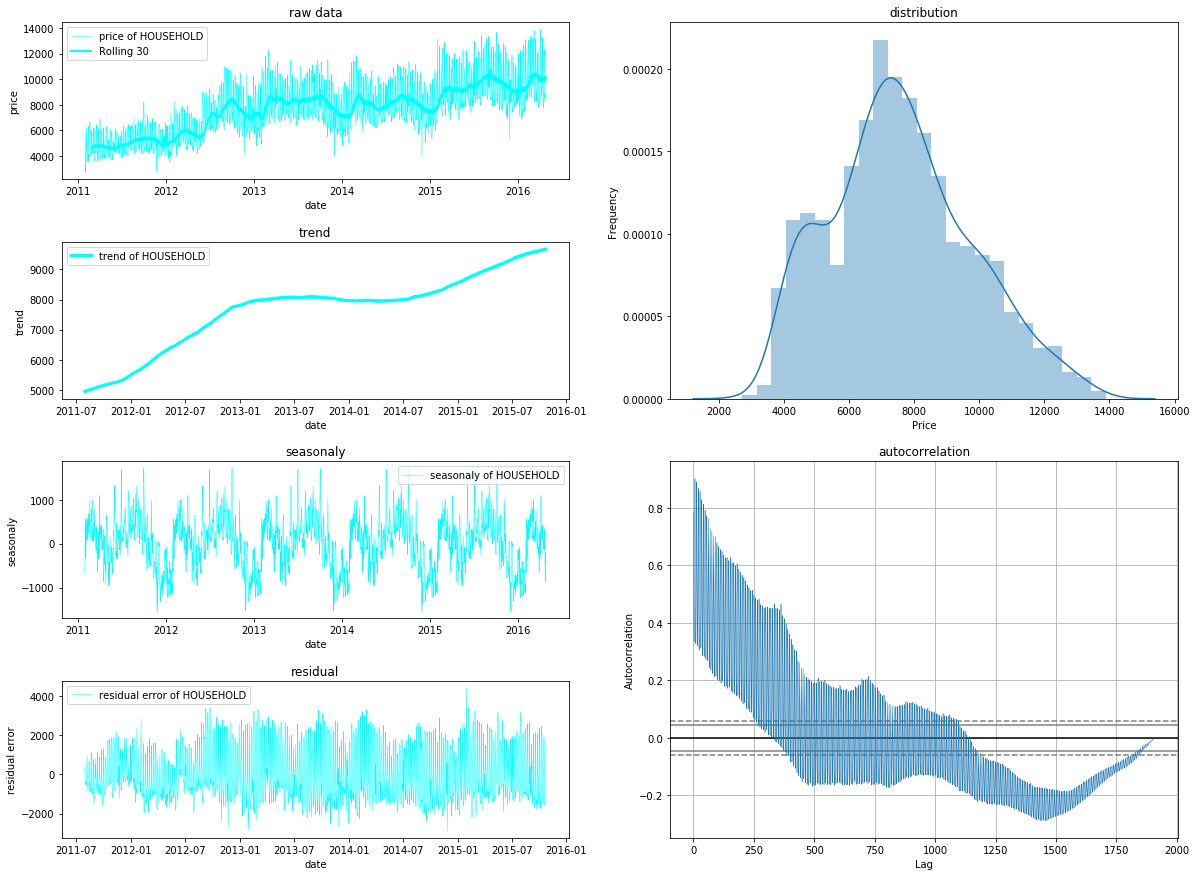

In [35]:
# HOUSEHOLD of cat
plot_ts_decomp("cate_group", "HOUSEHOLD", 365, "aqua");

Analised Data:FOODS


c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\Users\meigu\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

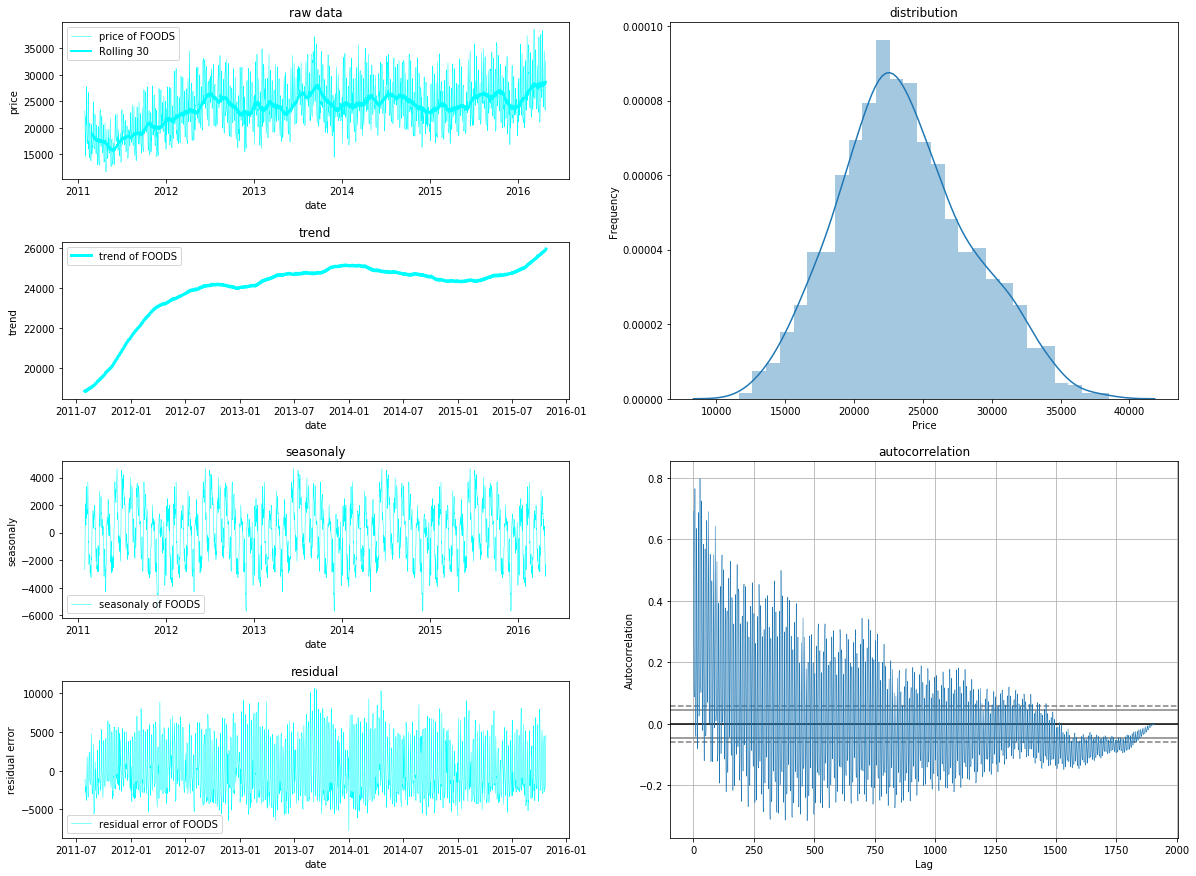

In [36]:
# FOODS of cat
plot_ts_decomp("cate_group", "FOODS", 365, "aqua");